In [1]:

import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

In [2]:
X

,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
Year,,,,,
2010,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN
2012,0,NaN,NaN,NaN,NaN
2013,1,0,NaN,NaN,NaN
2014,2,1,0,NaN,NaN
2015,3,2,1,0,NaN
2016,4,3,2,1,0
2017,5,4,3,2,1
2018,6,5,4,3,2


In [3]:
y

,y_step_3,y_step_2,y_step_1
Year,,,
2010,2,1,0
2011,3,2,1
2012,4,3,2
2013,5,4,3
2014,6,5,4
2015,7,6,5
2016,8,7,6
2017,9,8,7
2018,10,9,8


The above illustrates how a dataset would be prepared similar to the *Defining a Forecast* figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is `y_step_1`. The missing values we could either fill-in or drop.

# Multistep Forecasting Strategies #

There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses.

### Multioutput model

Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/uFsHiqr.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Direct strategy

Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/HkolNMV.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Recursive strategy

Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/sqkSFDn.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### DirRec strategy

A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as *new* lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/B7KAvAO.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

# Example - Flu Trends #

In this example we'll apply the MultiOutput and Direct strategies to the *Flu Trends* data from Lesson 4, this time making true forecasts for multiple weeks beyond the training period.

We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

The hidden cell sets up the example and defines a helper function `plot_multistep`.

In [4]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("../input/ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")

In [5]:
print(flu_trends.shape, flu_trends.index, '\n', flu_trends.dtypes)

(366, 131) RangeIndex(start=0, stop=366, step=1) 
 Week                       object
AInfluenza                  int64
AcuteBronchitis             int64
BodyTemperature             int64
BraunThermoscan             int64
                            ...  
TypeAInfluenza              int64
UpperRespiratory            int64
WalkingPneumonia            int64
WhatToDoIfYouHaveTheFlu     int64
FluVisits                   int64
Length: 131, dtype: object


In [6]:
flu_trends.head()

,Week,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
0,2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,...,16,6,13,25,34,30,25,24,15,180
1,2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,...,16,7,8,27,32,27,28,29,9,115
2,2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,...,16,6,9,24,28,25,25,25,9,132
3,2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,...,8,5,12,21,26,26,29,24,13,109
4,2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,...,8,8,12,33,29,21,27,30,9,120


In [7]:
pd.PeriodIndex(flu_trends.Week, freq="W")

PeriodIndex(['2009-06-29/2009-07-05', '2009-07-06/2009-07-12',
             '2009-07-13/2009-07-19', '2009-07-20/2009-07-26',
             '2009-07-27/2009-08-02', '2009-08-03/2009-08-09',
             '2009-08-10/2009-08-16', '2009-08-17/2009-08-23',
             '2009-08-24/2009-08-30', '2009-08-31/2009-09-06',
             ...
             '2016-04-25/2016-05-01', '2016-05-02/2016-05-08',
             '2016-05-09/2016-05-15', '2016-05-16/2016-05-22',
             '2016-05-23/2016-05-29', '2016-05-30/2016-06-05',
             '2016-06-06/2016-06-12', '2016-06-13/2016-06-19',
             '2016-06-20/2016-06-26', '2016-06-27/2016-07-03'],
            dtype='period[W-SUN]', name='Week', length=366)

In [8]:
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


In [9]:
flu_trends.FluVisits

Week
2009-06-29/2009-07-05    180
2009-07-06/2009-07-12    115
2009-07-13/2009-07-19    132
2009-07-20/2009-07-26    109
2009-07-27/2009-08-02    120
                        ... 
2016-05-30/2016-06-05     90
2016-06-06/2016-06-12     55
2016-06-13/2016-06-19     33
2016-06-20/2016-06-26     27
2016-06-27/2016-07-03     22
Freq: W-SUN, Name: FluVisits, Length: 366, dtype: int64

First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [10]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [11]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna() #dropna, 8 last weeks of y will be missing the flu_trends.index
y.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0


In [12]:
print(flu_trends.index,'\n\n',X.index,'\n\n',y.index)

PeriodIndex(['2009-06-29/2009-07-05', '2009-07-06/2009-07-12',
             '2009-07-13/2009-07-19', '2009-07-20/2009-07-26',
             '2009-07-27/2009-08-02', '2009-08-03/2009-08-09',
             '2009-08-10/2009-08-16', '2009-08-17/2009-08-23',
             '2009-08-24/2009-08-30', '2009-08-31/2009-09-06',
             ...
             '2016-04-25/2016-05-01', '2016-05-02/2016-05-08',
             '2016-05-09/2016-05-15', '2016-05-16/2016-05-22',
             '2016-05-23/2016-05-29', '2016-05-30/2016-06-05',
             '2016-06-06/2016-06-12', '2016-06-13/2016-06-19',
             '2016-06-20/2016-06-26', '2016-06-27/2016-07-03'],
            dtype='period[W-SUN]', name='Week', length=366) 

 PeriodIndex(['2009-06-29/2009-07-05', '2009-07-06/2009-07-12',
             '2009-07-13/2009-07-19', '2009-07-20/2009-07-26',
             '2009-07-27/2009-08-02', '2009-08-03/2009-08-09',
             '2009-08-10/2009-08-16', '2009-08-17/2009-08-23',
             '2009-08-24/2009-08-30',

In [13]:
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [14]:
X.tail()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2016-04-11/2016-04-17,712.0,955.0,1100.0,1326.0
2016-04-18/2016-04-24,616.0,712.0,955.0,1100.0
2016-04-25/2016-05-01,578.0,616.0,712.0,955.0
2016-05-02/2016-05-08,455.0,578.0,616.0,712.0
2016-05-09/2016-05-15,305.0,455.0,578.0,616.0


In [15]:
y.tail()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2016-04-11/2016-04-17,616,578.0,455.0,305.0,211.0,156.0,124.0,90.0
2016-04-18/2016-04-24,578,455.0,305.0,211.0,156.0,124.0,90.0,55.0
2016-04-25/2016-05-01,455,305.0,211.0,156.0,124.0,90.0,55.0,33.0
2016-05-02/2016-05-08,305,211.0,156.0,124.0,90.0,55.0,33.0,27.0
2016-05-09/2016-05-15,211,156.0,124.0,90.0,55.0,33.0,27.0,22.0


### Multioutput model

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [16]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [17]:
X_train.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [18]:
y_fit.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,28.079850,67.535191,110.102710,153.156716,197.280630,240.687856,276.813034,307.382720
2009-07-06/2009-07-12,296.928680,360.793442,425.366943,463.901064,489.023041,476.204228,465.969402,465.721786
2009-07-13/2009-07-19,90.912369,131.237771,149.578386,178.011476,182.835672,228.378204,273.812963,297.607147
2009-07-20/2009-07-26,188.758284,208.777014,233.320469,241.995135,290.235135,327.032434,345.184592,368.982347
2009-07-27/2009-08-02,105.120911,128.966953,155.169063,189.992365,213.930748,243.852517,272.948251,294.152355


In [19]:
X_test.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2014-08-25/2014-08-31,18.0,14.0,18.0,18.0
2014-09-01/2014-09-07,26.0,18.0,14.0,18.0
2014-09-08/2014-09-14,38.0,26.0,18.0,14.0
2014-09-15/2014-09-21,45.0,38.0,26.0,18.0
2014-09-22/2014-09-28,47.0,45.0,38.0,26.0


In [20]:
y_pred.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2014-08-25/2014-08-31,47.100337,84.883562,126.162075,167.311492,209.825057,250.207311,283.654452,312.403024
2014-09-01/2014-09-07,55.892505,95.054026,136.675357,177.886897,218.165656,256.665631,289.113997,316.611490
2014-09-08/2014-09-14,70.311121,109.863705,150.933058,190.394310,229.238803,266.220484,297.152888,323.449643
2014-09-15/2014-09-21,74.375308,112.615330,151.658743,189.518258,227.133712,264.614526,295.904945,322.089465
2014-09-22/2014-09-28,74.132494,110.131429,147.487402,184.076652,222.279166,260.683261,292.300392,318.926953


In [21]:
print(X_train.shape, y_fit.shape, X_test.shape, y_pred.shape)

(269, 4) (269, 8) (90, 4) (90, 8)


Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

In [22]:
#squared: bool, default=True: If True returns MSE value, if False returns RMSE value.
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 389.12
Test RMSE: 582.33


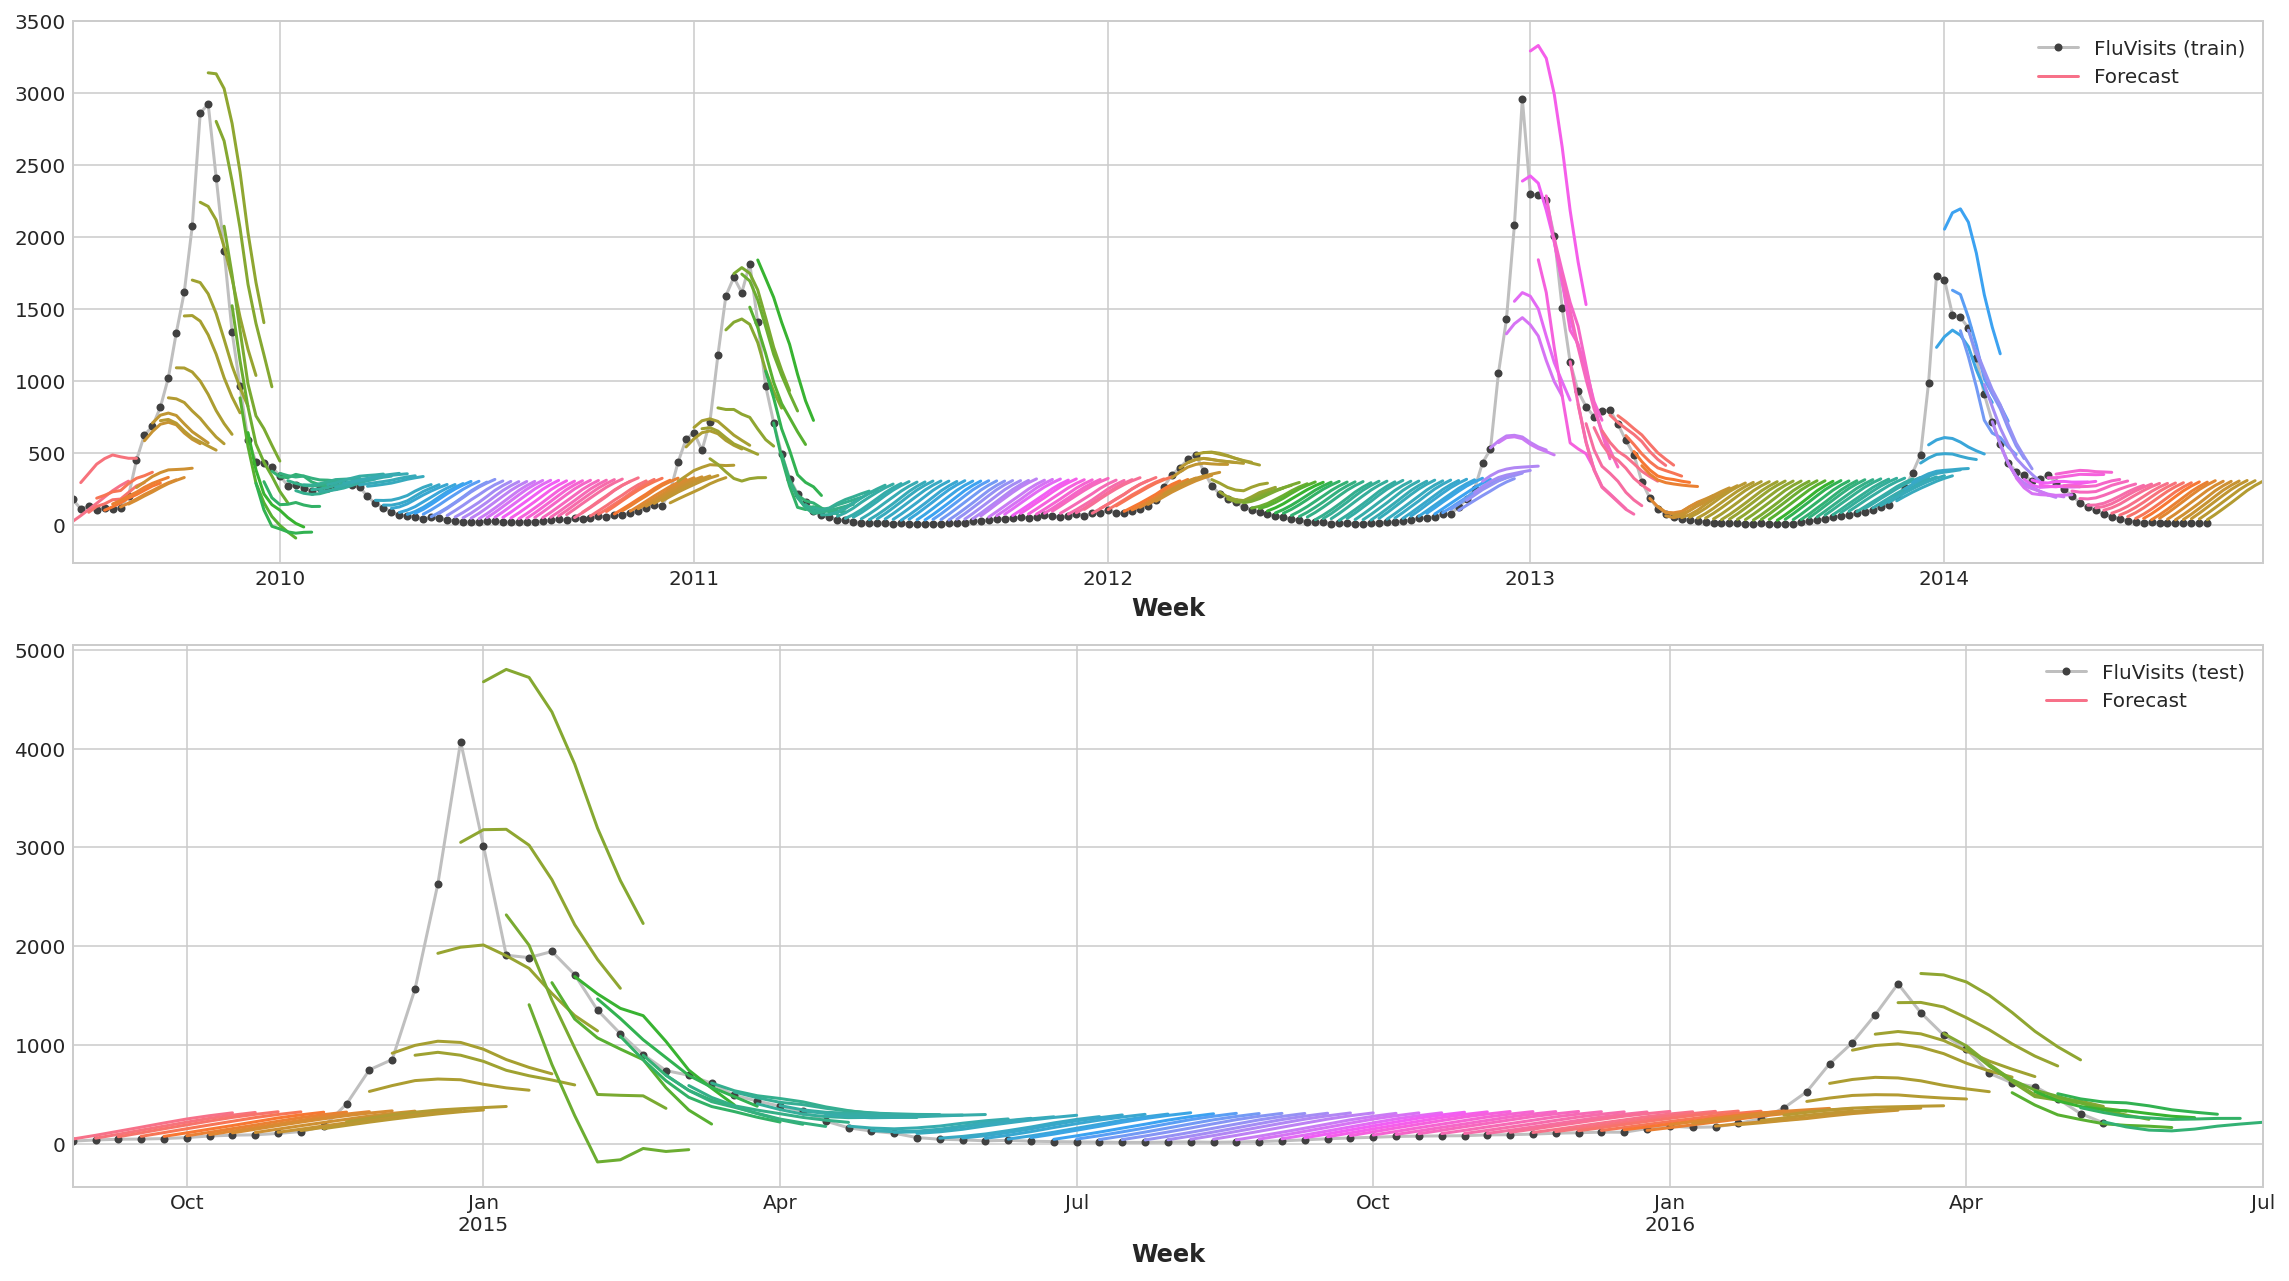

In [23]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))

ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct strategy

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's `MultiOutputRegressor`.

In [24]:
#Multi target regression.
#This strategy consists of fitting one regressor per target. 
#This is a simple strategy for extending regressors that do not natively support multi-target regression.
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [25]:
X_train.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [26]:
y_fit.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,179.840027,114.697037,131.859451,109.026161,119.887444,114.710693,122.911079,204.793304
2009-07-06/2009-07-12,115.014732,131.972000,109.173164,120.187019,114.978989,123.312866,205.634567,454.264496
2009-07-13/2009-07-19,131.970032,109.039955,120.042946,115.127563,123.121025,205.576324,454.102264,628.509399
2009-07-20/2009-07-26,109.067657,120.128670,114.838860,123.139542,205.063965,453.871185,628.087280,687.359985
2009-07-27/2009-08-02,120.024956,115.681541,122.016914,204.978989,454.024933,626.458008,686.193481,819.402039


In [27]:
X_test.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2014-08-25/2014-08-31,18.0,14.0,18.0,18.0
2014-09-01/2014-09-07,26.0,18.0,14.0,18.0
2014-09-08/2014-09-14,38.0,26.0,18.0,14.0
2014-09-15/2014-09-21,45.0,38.0,26.0,18.0
2014-09-22/2014-09-28,47.0,45.0,38.0,26.0


In [28]:
y_pred.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2014-08-25/2014-08-31,18.140884,16.881290,18.559252,21.576357,32.111931,35.642635,39.735867,52.713200
2014-09-01/2014-09-07,24.515759,25.806377,35.830750,40.551453,47.147789,59.971001,68.785172,75.866577
2014-09-08/2014-09-14,45.666988,51.251072,52.233646,70.823776,73.328804,90.517448,94.758766,91.844292
2014-09-15/2014-09-21,56.399742,65.104530,67.063454,79.442497,83.439011,85.976303,100.207359,96.863960
2014-09-22/2014-09-28,51.360065,60.170395,58.715244,67.784500,71.809738,65.935020,88.013092,57.363556


XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

In [29]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 1.22
Test RMSE: 526.45


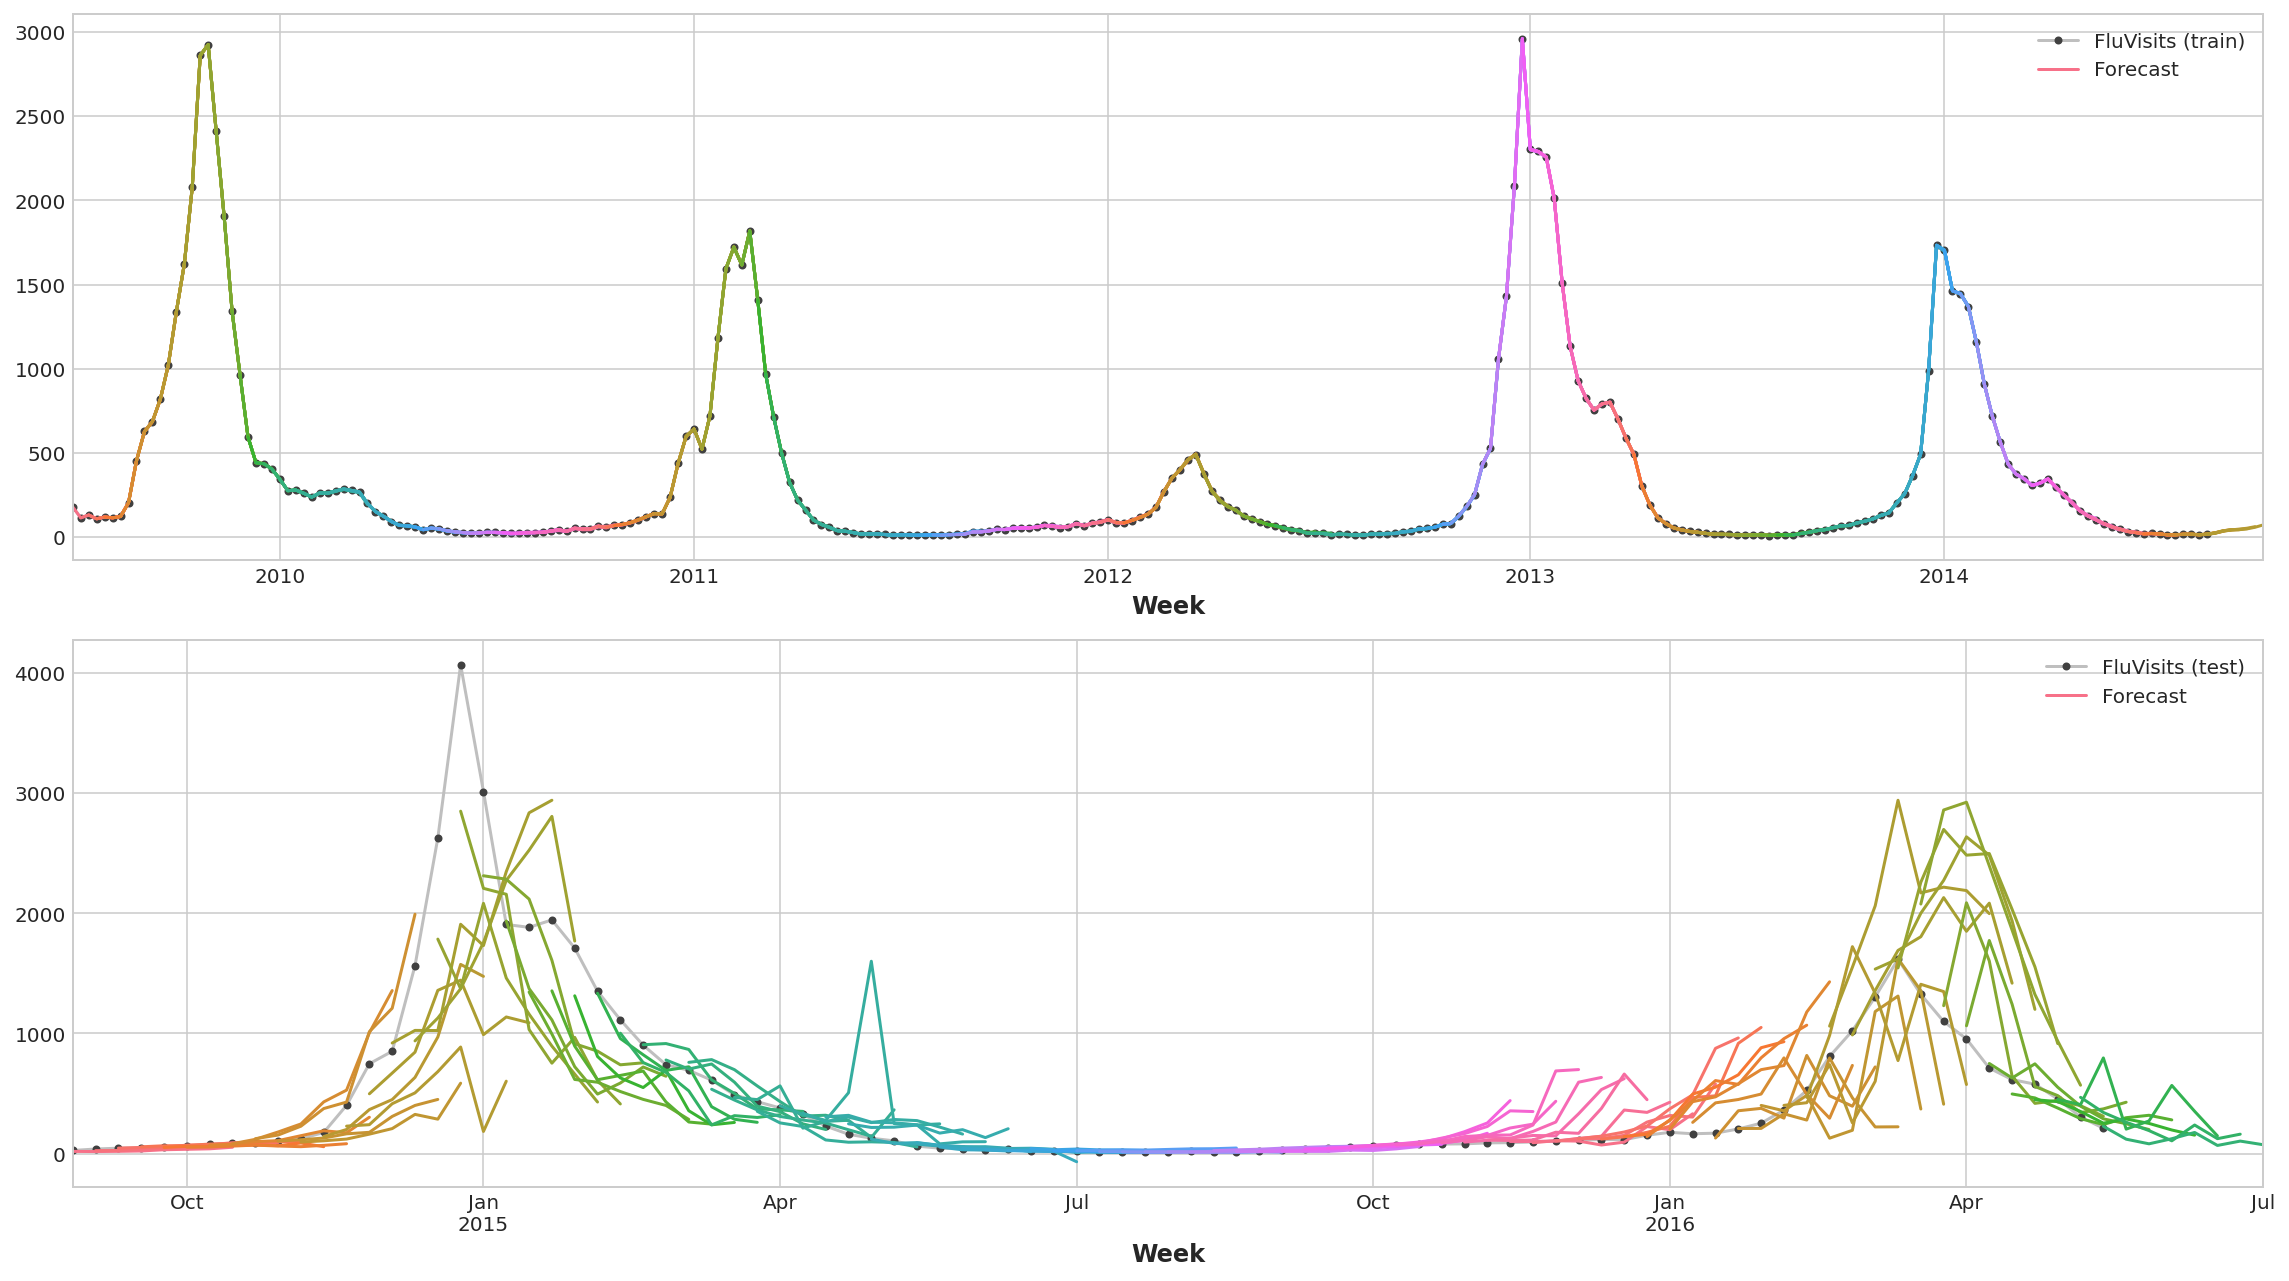

In [30]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))

ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

To use the DirRec strategy, you would only need to replace `MultiOutputRegressor` with another scikit-learn wrapper, `RegressorChain`. The Recursive strategy we would need to code ourselves.
